In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.visualization as visualization
import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

visualization.tutorial_matplotlib()

INFO: Using numpy backend


In [3]:
hands, labels, bone_list = data_utils.load_hands()

In [4]:
print(hands.shape)
print(labels)

(52, 22, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
label_to_str = {0: 'Grab', 1: 'Expand'}
label_to_color = {0: (102/255, 178/255, 255/255, 1.), 1: (255/255, 178/255, 102/255, 1.)}
first_grab_hand = hands[labels==0][0]
first_expand_hand = hands[labels==1][0]

In [6]:
def plot_hand(hand, bone_list):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    x = hand[:, 0]
    y = hand[:, 1]
    z = hand[:, 2]

    sc = ax.scatter(x, y, z, s=40)
    for bone in bone_list:
        start_bone_idx = bone[0]
        end_bone_idx = bone[1]
        ax.plot(
            xs=[x[start_bone_idx], x[end_bone_idx]],
            ys=[y[start_bone_idx], y[end_bone_idx]],
            zs=[z[start_bone_idx], z[end_bone_idx]],
        )

<IPython.core.display.Javascript object>


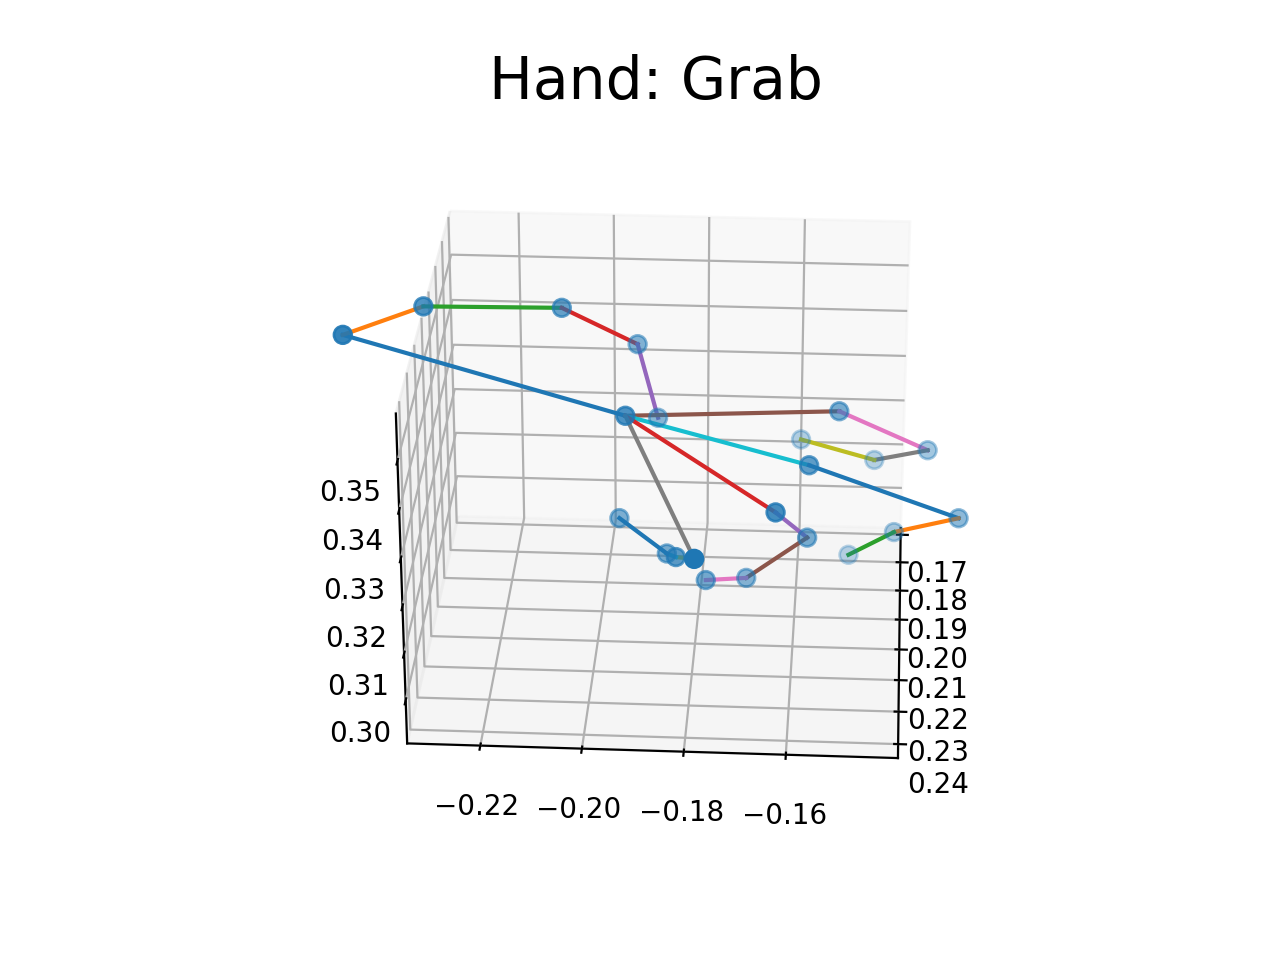

In [7]:
%matplotlib notebook

plot_hand(first_grab_hand, bone_list)
plt.title(f"Hand: {label_to_str[0]}");

<IPython.core.display.Javascript object>


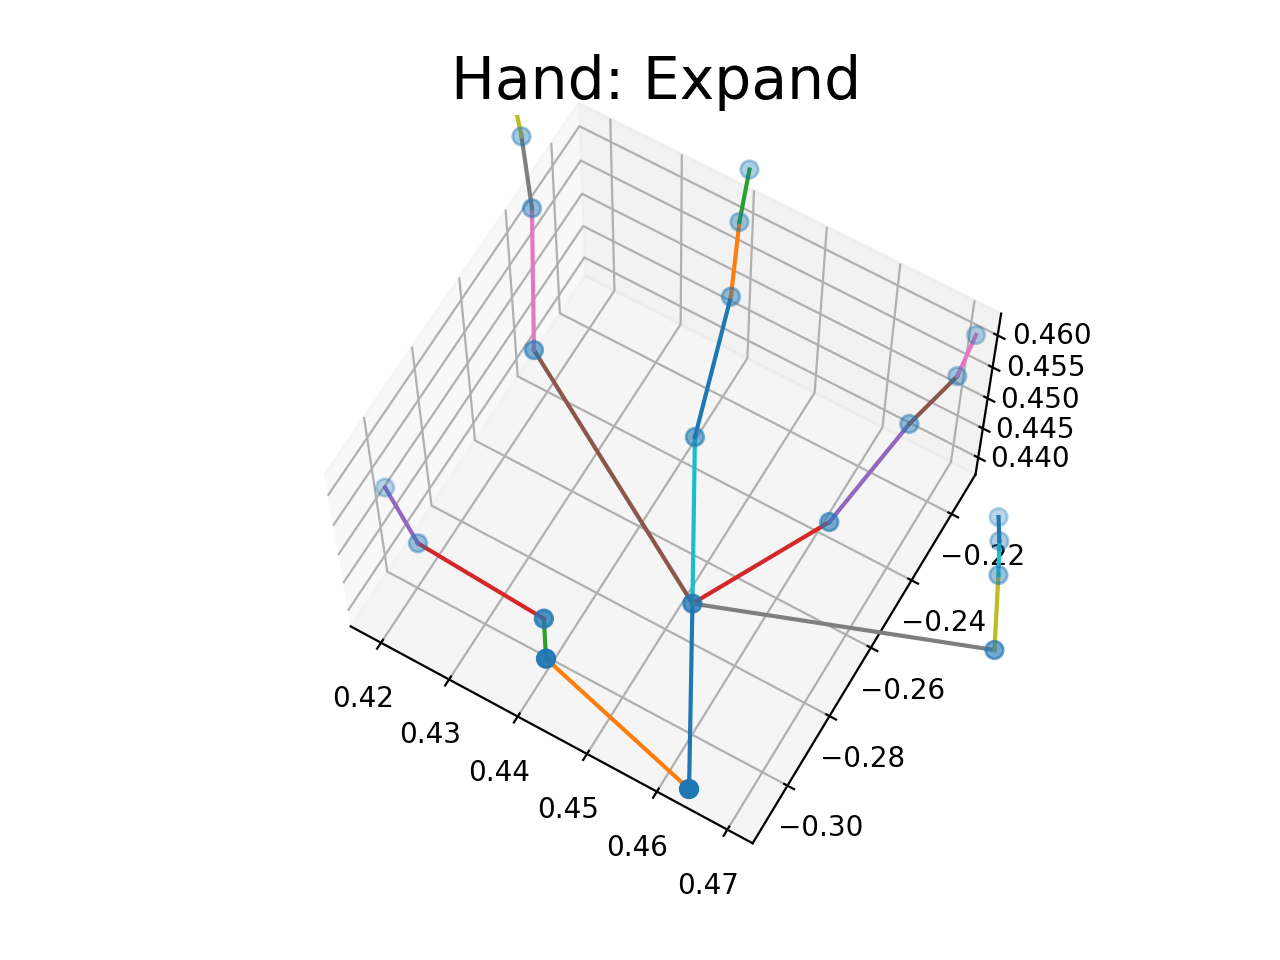

In [8]:
plot_hand(first_expand_hand, bone_list)
plt.title(f"Hand: {label_to_str[1]}");

<IPython.core.display.Javascript object>


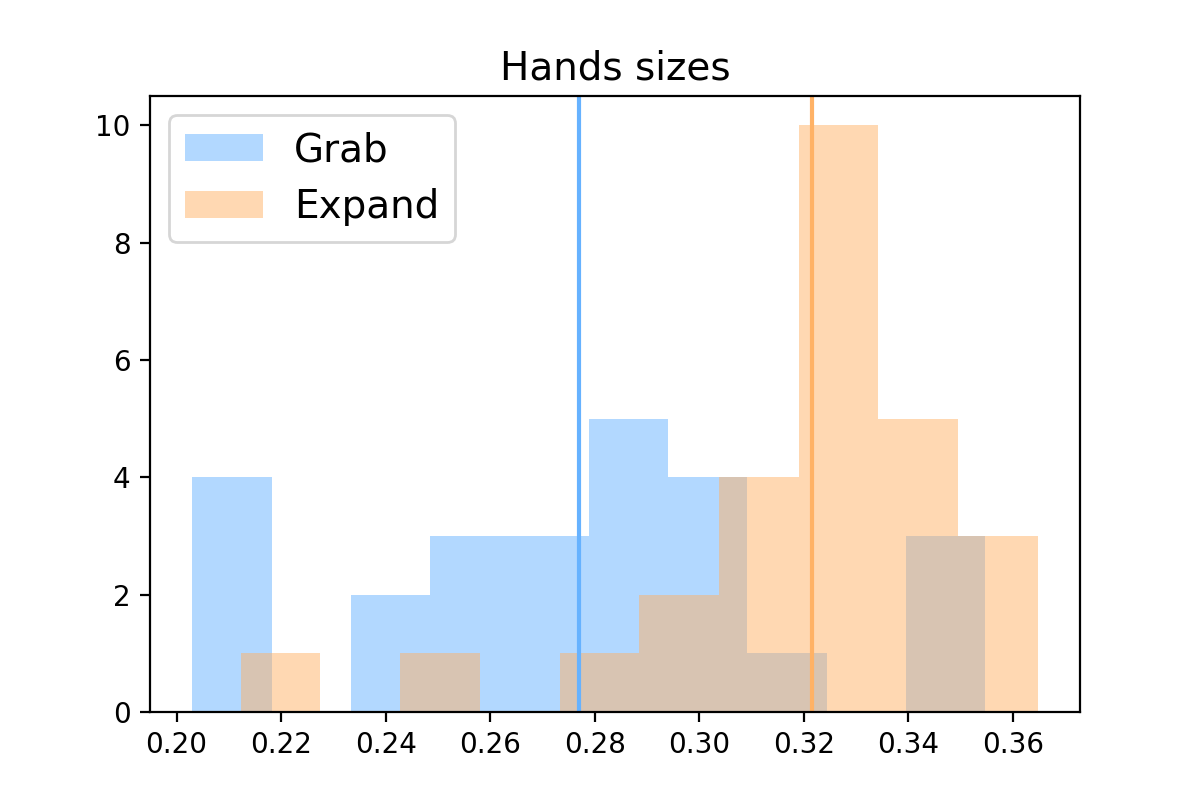

In [9]:
m_ambient = 3
k_landmarks = 22

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

sizes = matrices_metric.norm(preshape.center(hands))

plt.figure(figsize=(6, 4))
for label, col in label_to_color.items():
    label_sizes = sizes[labels==label]
    plt.hist(label_sizes, color=col, label=label_to_str[label], alpha=0.5, bins=10)
    plt.axvline(gs.mean(label_sizes),  color=col)
plt.legend(fontsize=14)
plt.title('Hands sizes', fontsize=14);

In [10]:
from scipy import stats

signif_level = 0.05

tstat, pvalue = stats.ttest_ind(sizes[labels==0], sizes[labels==1])
print(pvalue < signif_level)

True


<IPython.core.display.Javascript object>


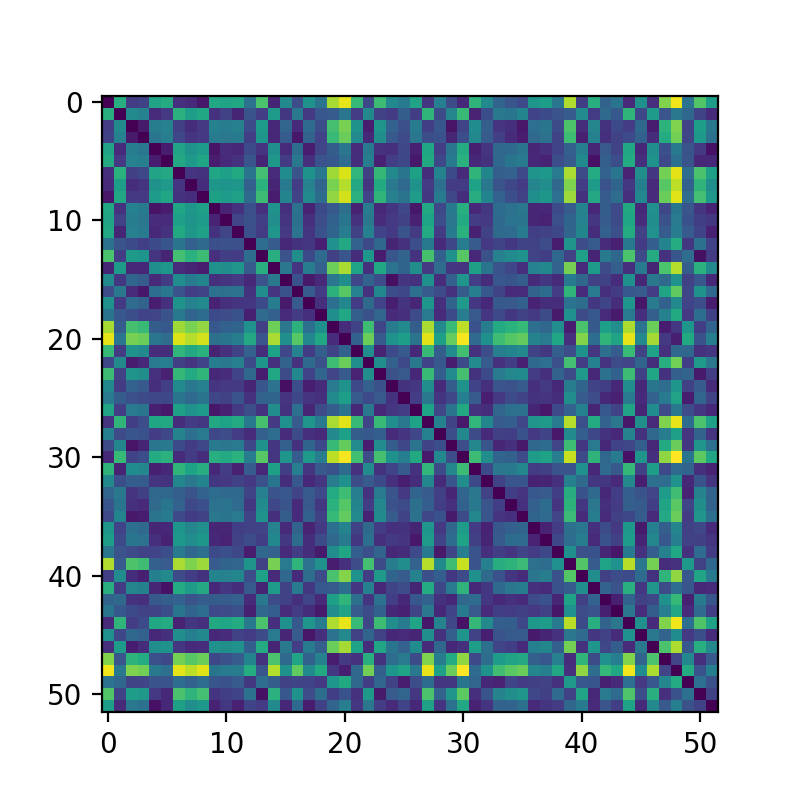

In [11]:
from geomstats.geometry.euclidean import EuclideanMetric

eucl_metric = EuclideanMetric(3*22)
hands_vec = hands.reshape(52, -1)
eucl_pair_dist = eucl_metric.dist_pairwise(hands_vec)


plt.figure(figsize=(4, 4))
plt.imshow(eucl_pair_dist);

In [12]:
hands_preshape = preshape.projection(hands)
print(hands_preshape.shape)
print(preshape.belongs(hands_preshape))
print(gs.isclose(matrices_metric.norm(hands_preshape), 1.))

(52, 22, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [13]:
base_point = hands_preshape[0]

hands_shape = preshape.align(point=hands_preshape, base_point=base_point)
print(hands_shape.shape)

(52, 22, 3)


In [14]:
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)

<IPython.core.display.Javascript object>


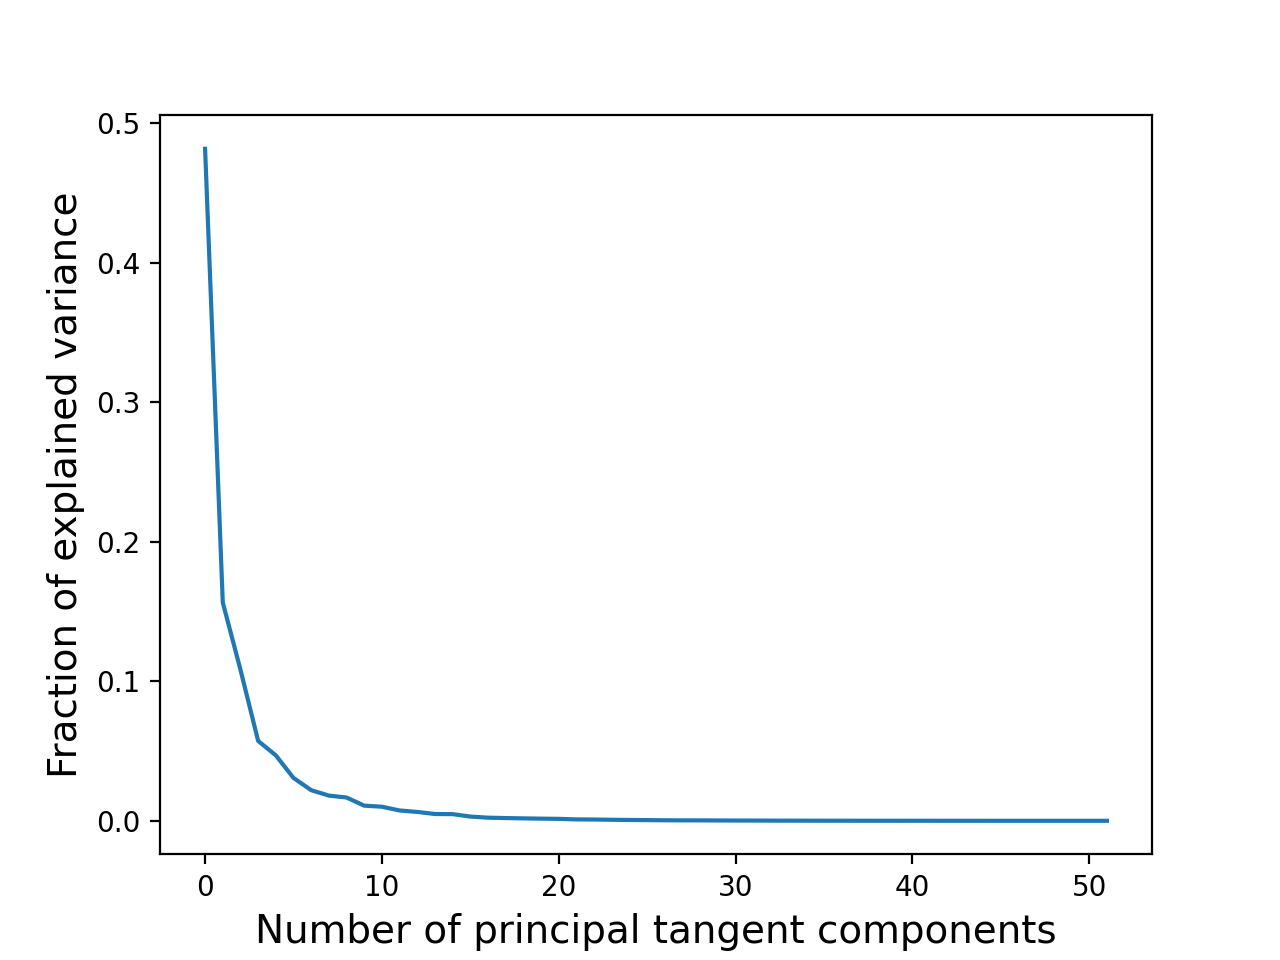

In [15]:
from geomstats.learning.pca import TangentPCA

tpca = TangentPCA(kendall_metric)
tpca.fit(hands_shape)

plt.figure()
plt.plot(
    tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);

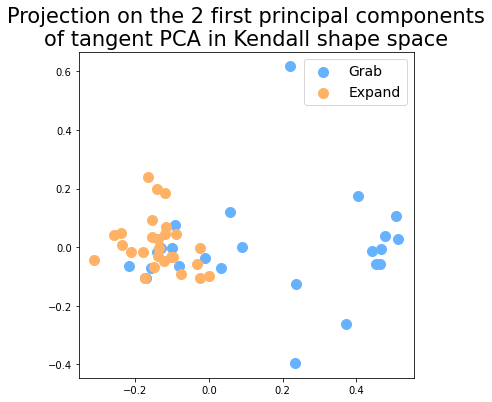

In [16]:
%matplotlib inline
X = tpca.transform(hands_shape)

plt.figure(figsize=(6, 6))

for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label]);
plt.legend(fontsize=14)
plt.title(
    'Projection on the 2 first principal components'
    '\nof tangent PCA in Kendall shape space');

In [17]:
dist_pairwise = kendall_metric.dist_pairwise(hands_shape)
print(dist_pairwise.shape)

(52, 52)


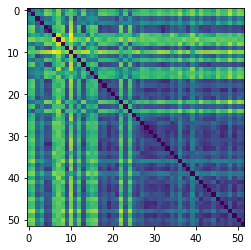

In [18]:
plt.figure(figsize=(4, 4))
plt.imshow(dist_pairwise);